In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/colab_libs')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import random
import numpy as np
from PIL import Image
from glob import glob

import os
from typing import List, Tuple, Optional
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [26]:
class TripletDataset(Dataset):
    def __init__(self,
                 image_paths: List[str],
                 labels: Optional[List[str]] = None,
                 transform = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_to_indices = {}

        for idx, label in enumerate(self.labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

        self.unique_labels = list(self.label_to_indices.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor_image = Image.open(anchor_path).convert('RGB')
        anchor_label = self.labels[idx]

        pos_indices = self.label_to_indices[anchor_label]
        pos_idx = idx
        while pos_idx == idx:
            pos_idx = random.choice(pos_indices)

        pos_path = self.image_paths[pos_idx]
        pos_image = Image.open(pos_path).convert('RGB')

        neg_label = anchor_label
        while neg_label == anchor_label:
            neg_label = random.choice(self.unique_labels)

        neg_idx = random.choice(self.label_to_indices[neg_label])
        neg_path = self.image_paths[neg_idx]
        neg_image = Image.open(neg_path).convert('RGB')

        if self.transform:
            anchor_image = self.transform(anchor_image)
            pos_image = self.transform(pos_image)
            neg_image = self.transform(neg_image)
        return anchor_image, pos_image, neg_image, anchor_label


In [27]:
def get_data_loader(image_paths = None,
                    labels = None,
                    batch_size = 32,
                    image_size = 224,
                    train_split = 0.8):
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    split_idx = int(len(image_paths) * train_split)
    train_paths, val_paths = image_paths[:split_idx], image_paths[split_idx:]
    train_labels, val_labels = labels[:split_idx], labels[split_idx:]

    train_dataset = TripletDataset(train_paths, train_labels, train_transform)
    val_dataset = TripletDataset(val_paths, val_labels, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader


In [28]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)

        loss = F.relu(pos_dist - neg_dist + self.margin)

        return loss.mean()


In [29]:
class NetVLAD(nn.Module):
    def __init__(self, num_cluster=64, dim=512, alpha=100.0):
        super(NetVLAD, self).__init__()
        self.num_cluster = num_cluster
        self.dim = dim
        self.alpha = alpha

        self.conv = nn.Conv2d(dim, num_cluster, kernel_size=(1,1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_cluster, dim))

    def init_params(self, clsts):
        if clsts is not None:
            self.conv.weight = nn.Parameter(
                (2.0 * self.alpha * clsts / self.dim).unsqueeze(-1).unsqueeze(-1)
            )

            self.conv.bias = nn.Parameter(
                - self.alpha * clsts.norm(dim=1)
            )

            self.centroids = nn.Parameter(clsts)

    def forward(self, x):
        B, D, H, W = x.shape
        soft_assign = self.conv(x)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(B, D, -1)
        soft_assign = soft_assign.view(B, self.num_cluster, -1)

        vlad = torch.zeros([B, self.num_cluster, D], dtype=x.dtype, device=x.device)

        for k in range(self.num_cluster):
            residual = x_flatten - self.centroids[k:k+1].unsqueeze(2)

            residual = residual * soft_assign[:, k:k+1, :]

            vlad[:, k, :] = residual.sum(dim=2)

        vlad = vlad.view(B, -1)

        vlad = F.normalize(vlad, p=2, dim=1)

        vlad = F.normalize(vlad, p=2, dim=1)

        return vlad

In [30]:
class CNNNetVLAD(nn.Module):
    def __init__(self,
                 num_cluster=64,
                 encoder_dim=512,
                 pretrained=True,
                 backbone='vgg16'):
        super(CNNNetVLAD, self).__init__()

        self.num_cluster = num_cluster
        self.encoder_dim = encoder_dim

        if backbone == 'vgg16':
            vgg = models.vgg16(pretrained=pretrained)
            self.encoder = nn.Sequential(*list(vgg.features.children())[:2])
            self.encoder_dim = 64

        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
            self.encoder = nn.Sequential(*list(resnet.features.children())[:-2])
            self.encoder_dim = 2048

        elif backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
            self.encoder = nn.Sequential(*list(resnet.features.children())[:-2])
            self.encoder_dim = 512

        else:
            raise ValueError(f"Unsupported backbone {backbone}")

        self.netvlad = NetVLAD(num_cluster=self.num_cluster, dim=self.encoder_dim)

    def forward(self, x):
        x = self.encoder(x)

        vlad_encoding = self.netvlad(x)

        return vlad_encoding


In [31]:
class NetVLADTrainer:
    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 num_epochs,
                 learning_rate,
                 device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        self.criterion = TripletLoss(margin=0.3)

        self.train_losses = []
        self.val_losses = []

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx, (anchor_images, pos_images, neg_images, anchor_labels) in enumerate(pbar):
            anchor = anchor_images.to(self.device)
            positive = pos_images.to(self.device)
            negative = neg_images.to(self.device)
            emb_anchor = self.model(anchor)
            emb_positive = self.model(positive)
            emb_negative = self.model(negative)

            loss = self.criterion(emb_anchor, emb_positive, emb_negative)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(self.train_loader)
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate(self):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for batch_idx, (anchor_images, pos_images, neg_images, _) in enumerate(pbar):
                anchor = anchor_images.to(self.device)
                positive = pos_images.to(self.device)
                negative = neg_images.to(self.device)

                emb_anchor = self.model(anchor)
                emb_positive = self.model(positive)
                emb_negative = self.model(negative)

                loss = self.criterion(emb_anchor, emb_positive, emb_negative)
                total_loss += loss.item()
                pbar.set_postfix({'val_loss': loss.item()})

        avg_loss = total_loss / len(self.val_loader)
        self.val_losses.append(avg_loss)
        return avg_loss

    def train(self):
        print(f"Starting training for {self.num_epochs} epochs on device {self.device}…")
        for epoch in range(1, self.num_epochs+1):
            print(f"\nEpoch {epoch}/{self.num_epochs}")
            train_loss = self.train_epoch()
            val_loss   = self.validate()

            print(f"--> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        print("\nTraining complete!")

    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses,   label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Losses')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_model(self, path='netvlad_model.pth'):
        torch.save({
            'model_state_dict':     self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses':         self.train_losses,
            'val_losses':           self.val_losses,
        }, path)
        print(f"Model checkpoint saved to {path}")

    def load_model(self, path='netvlad_model.pth'):
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses   = checkpoint['val_losses']
        print(f"Model checkpoint loaded from {path}")



In [32]:
model = CNNNetVLAD(
    num_cluster=64,
    encoder_dim=512,
    pretrained=True,
    backbone='vgg16'
)

In [33]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/Feature-Extraction-with-Pytorch/Data/Vyronasdbmin/Images"
labels_path = "/content/drive/MyDrive/Colab Notebooks/Feature-Extraction-with-Pytorch/Data/Vyronasdbmin/label/label.txt"
with open(labels_path, "r", encoding="utf-8") as f:
    labels = [line.strip() for line in f.readlines() if line.strip()]
image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
train_loader, val_loader = get_data_loader(
    image_paths=image_paths,
    labels=labels,
    batch_size=8,
    image_size=128,
    train_split=0.8
)

In [13]:
next(iter(train_loader))

[tensor([[[[-0.2171, -0.1999, -0.1657,  ..., -0.2342, -0.3027, -0.7308],
           [-0.1828, -0.1657, -0.1486,  ..., -0.4739, -0.8164, -0.6452],
           [-0.1314, -0.1314, -0.1314,  ..., -0.8164, -0.6281, -0.3883],
           ...,
           [-1.1589, -0.0629, -0.0629,  ..., -1.7925, -1.7925, -1.7412],
           [-0.6965, -0.1657, -0.3883,  ..., -1.7925, -1.7925, -1.7583],
           [-0.4568, -0.3027, -0.3883,  ..., -1.7240, -1.7925, -1.7925]],
 
          [[ 0.2577,  0.2577,  0.2752,  ...,  0.2402,  0.1176, -0.3901],
           [ 0.2927,  0.3102,  0.3102,  ..., -0.0749, -0.5476, -0.3550],
           [ 0.3277,  0.3277,  0.3277,  ..., -0.6001, -0.4076, -0.1099],
           ...,
           [-1.0728,  0.0126,  0.0301,  ..., -1.7031, -1.6856, -1.6155],
           [-0.6001, -0.0924, -0.3025,  ..., -1.6856, -1.7031, -1.6506],
           [-0.3901, -0.2500, -0.2850,  ..., -1.5980, -1.7031, -1.7031]],
 
          [[ 0.8099,  0.8099,  0.8622,  ...,  0.7925,  0.6182,  0.0431],
           [ 

In [38]:
trainer = NetVLADTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=1e-6,
    num_epochs=2,
    device='cuda'
)

Starting training for 2 epochs on device cuda…

Epoch 1/2


Validation: 100%|██████████| 23/23 [00:06<00:00,  3.79it/s, val_loss=0.258]


--> Train Loss: 0.2428 | Val Loss: 0.2290

Epoch 2/2


Validation: 100%|██████████| 23/23 [00:07<00:00,  3.16it/s, val_loss=0.27]


--> Train Loss: 0.2438 | Val Loss: 0.2257

Training complete!


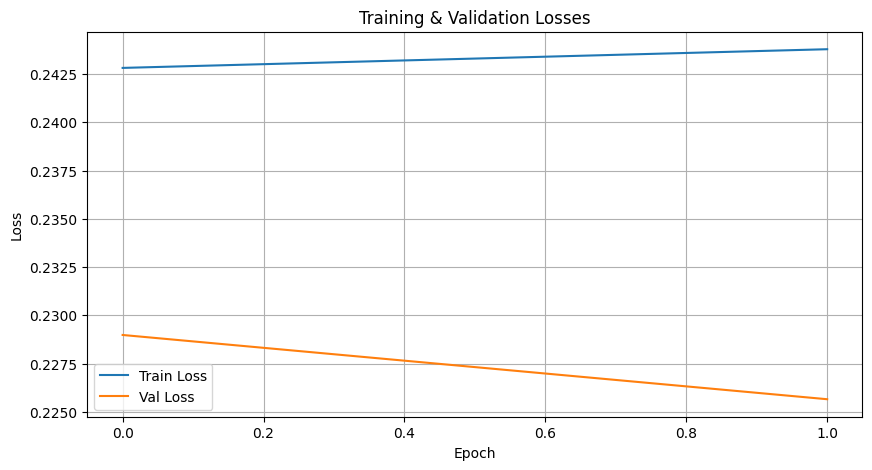

Model checkpoint saved to netvlad_model.pth


In [39]:
trainer.train()
trainer.plot_losses()
trainer.save_model()

### Inference

In [16]:
def extract_features(model, image_path, transform, device):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(image)

    return features.cpu().numpy()


In [17]:
def compute_similarity(query_features, database_features):
    query_norm = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
    db_norm = database_features / np.linalg.norm(database_features, axis=1, keepdims=True)

    similarity = np.dot(query_norm, db_norm.T)
    return similarity

In [18]:
def retrieve_places(model, query_image_path, database_image_paths,
                   transform, device, top_k=5):
    model.eval()

    query_features = extract_features(model, query_image_path, transform, device)

    db_features = []
    for db_path in tqdm(database_image_paths, desc='Extracting DB features'):
        features = extract_features(model, db_path, transform, device)
        db_features.append(features)

    db_features = np.vstack(db_features)

    similarity = compute_similarity(query_features, db_features)

    top_indices = np.argsort(similarity[0])[::-1][:top_k]
    top_scores = similarity[0][top_indices]

    return top_indices, top_scores

In [19]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [41]:
query_path = '/content/building01_front_day.jpg'
db_paths = image_paths
top_indices, top_scores = retrieve_places(model, query_path, db_paths,
                                         inference_transform, device, top_k=5)
print(f"Top-5 matches: {top_indices}")
print(f"Scores: {top_scores}")

Extracting DB features: 100%|██████████| 900/900 [00:29<00:00, 30.58it/s]


Top-5 matches: [  1   0   7 735 739]
Scores: [0.9999998  0.9986645  0.99737984 0.99518025 0.99515474]
